In [1]:
import os
import sys

In [2]:
sys.path.append('../lib')

In [3]:
import cov_independence_test
import hsic_independence_test
import gen_processes

In [4]:
from importlib import reload

In [5]:
reload(cov_independence_test);
reload(hsic_independence_test);
reload(gen_processes);

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel

In [7]:
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [8]:
import scipy.stats as stats

In [9]:
from tqdm import tqdm

In [10]:
from itertools import product

In [11]:
import matplotlib.pyplot as plt

In [12]:
BIG_RESULT_MEMORY_PLACE = []

In [13]:
N_TIMESTEPS = 1800
SIG_KERNEL_SAMPLES_NO = 300
M_RUNS = 50
COVS = [0, 0.05, 0.1, 0.2, 0.3, 0.4]
#COVS = [0.3]
PROC_DIV = 8
RBF_SIGMA = 2

In [14]:
assert N_TIMESTEPS % SIG_KERNEL_SAMPLES_NO == 0, 'Cannot reshape such array properly'

In [15]:
processes = gen_processes.gen_ar_iid_samples_burn_in(N_TIMESTEPS+1, M_RUNS)

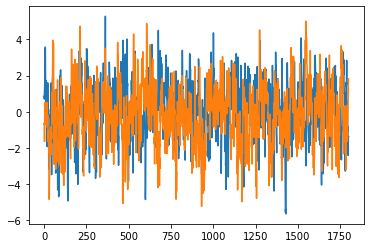

In [16]:
plt.plot(processes[0, :, 0])
plt.plot(processes[0, :, 1]);

In [17]:
def get_bootstrap_samples_lead_lag(X_raw, Y_raw):
    single_sample_length = int(N_TIMESTEPS / SIG_KERNEL_SAMPLES_NO)
        
    x_bootstrap_samples = torch.zeros(SIG_KERNEL_SAMPLES_NO, single_sample_length, 2)
    y_bootstrap_samples = torch.zeros(SIG_KERNEL_SAMPLES_NO, single_sample_length, 2)
    
    rng = np.random.default_rng(1234)
    
    for i in range(SIG_KERNEL_SAMPLES_NO):
        idx_low = rng.integers(0, N_TIMESTEPS - single_sample_length + 1)
        x_bootstrap_samples[i, :, 0] = X_raw[idx_low+1 : idx_low+single_sample_length+1]
        x_bootstrap_samples[i, :, 1] = X_raw[idx_low : idx_low+single_sample_length]
        y_bootstrap_samples[i, :, 0] = Y_raw[idx_low+1 : idx_low+single_sample_length+1]
        y_bootstrap_samples[i, :, 1] = Y_raw[idx_low : idx_low+single_sample_length]

    return x_bootstrap_samples, y_bootstrap_samples

In [18]:
hsic_results = {}
cov_results = {}

In [19]:
for cov in COVS:#[0, 0.3, 0.8]:    
    processes = gen_processes.gen_ar_iid_samples_burn_in(N_TIMESTEPS+1, M_RUNS, corr=cov)
    hsic_results[cov] = []
    cov_results[cov] = []
    for run in range(M_RUNS):
        X_raw = processes[run, :, 0]
        Y_raw = processes[run, :, 1]
        X_lead_lag_chopped, Y_lead_lag_chopped = get_bootstrap_samples_lead_lag(X_raw, Y_raw)
        
        X = X_raw[:N_TIMESTEPS]
        Y = Y_raw[:N_TIMESTEPS]
        
        hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        cov_test_result = cov_independence_test.get_test_result(X, Y)
        print('RUN:', run)
        print('HSIC:', hsic_test_result[1:])
        print('COV:', cov_test_result)

        hsic_results[cov].append(hsic_test_result)
        cov_results[cov].append(cov_test_result)
        
    print('==================== END COV {} ================='.format(cov))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]


RUN: 0
HSIC: (0.00020986711217019227, 0.02)
COV: (tensor(-0.0222), 0.5637762016029908)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.16it/s]


RUN: 1
HSIC: (8.03224686622972e-05, 0.1)
COV: (tensor(-0.1464), 0.8555494894912712)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


RUN: 2
HSIC: (2.156249212204031e-05, 0.68)
COV: (tensor(0.0224), 0.42310667416729053)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.22it/s]


RUN: 3
HSIC: (2.9853475839614063e-05, 0.56)
COV: (tensor(-0.0653), 0.6785299932816475)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.22it/s]


RUN: 4
HSIC: (0.00010002508399820087, 0.06)
COV: (tensor(-0.2495), 0.9441534752214008)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


RUN: 5
HSIC: (0.00010804855411805647, 0.04)
COV: (tensor(-0.2307), 0.9580212389119143)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


RUN: 6
HSIC: (3.8131910479188846e-05, 0.34)
COV: (tensor(-0.0068), 0.5185675384514798)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


RUN: 7
HSIC: (3.158530330638065e-05, 0.54)
COV: (tensor(-0.1428), 0.8732500765961182)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.20it/s]


RUN: 8
HSIC: (0.00018283561940179993, 0.0)
COV: (tensor(-0.1064), 0.7436313912901735)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.24it/s]


RUN: 9
HSIC: (3.429050761849517e-05, 0.4)
COV: (tensor(-0.0056), 0.5173030759383901)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


RUN: 10
HSIC: (6.141336016218801e-05, 0.28)
COV: (tensor(0.0981), 0.2287774081873668)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


RUN: 11
HSIC: (2.997480359678839e-05, 0.5)
COV: (tensor(0.0454), 0.36386043976343263)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.11it/s]


RUN: 12
HSIC: (1.7299101634948855e-05, 0.96)
COV: (tensor(-0.0448), 0.6065079247111943)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 13
HSIC: (5.7937431976018416e-05, 0.16)
COV: (tensor(-0.2520), 0.9692339907574036)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 14
HSIC: (2.8589592463657e-05, 0.8)
COV: (tensor(0.1341), 0.20551915489360284)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 15
HSIC: (7.68940391924211e-05, 0.18)
COV: (tensor(0.0533), 0.3396415568295831)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.89it/s]


RUN: 16
HSIC: (6.905282304670024e-05, 0.22)
COV: (tensor(0.0246), 0.4376364906252017)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.89it/s]


RUN: 17
HSIC: (5.3328884851655545e-05, 0.2)
COV: (tensor(-0.0636), 0.6961882079853388)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


RUN: 18
HSIC: (7.019760404425313e-05, 0.14)
COV: (tensor(-0.2175), 0.9492742070455934)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.08it/s]


RUN: 19
HSIC: (7.126454747652389e-05, 0.12)
COV: (tensor(-0.0209), 0.5584819549189244)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.12it/s]


RUN: 20
HSIC: (3.910350378388827e-05, 0.38)
COV: (tensor(0.2411), 0.06457515961678795)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


RUN: 21
HSIC: (0.00012112884861270601, 0.12)
COV: (tensor(-0.0546), 0.6461138570028064)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


RUN: 22
HSIC: (2.0687863982571386e-05, 0.68)
COV: (tensor(-0.0923), 0.7426317648598967)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


RUN: 23
HSIC: (2.570149825764645e-05, 0.88)
COV: (tensor(0.2009), 0.07996136098677453)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


RUN: 24
HSIC: (0.00010812280635574822, 0.1)
COV: (tensor(-0.1089), 0.8039488764026643)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


RUN: 25
HSIC: (5.420779312359514e-05, 0.28)
COV: (tensor(0.2454), 0.02560831389410978)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


RUN: 26
HSIC: (3.83784054804881e-05, 0.54)
COV: (tensor(-0.0108), 0.5346750795980418)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


RUN: 27
HSIC: (5.0560203771032874e-05, 0.3)
COV: (tensor(0.0322), 0.4195127027151182)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.09it/s]


RUN: 28
HSIC: (3.620662362480154e-05, 0.38)
COV: (tensor(0.1954), 0.1067943096985039)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


RUN: 29
HSIC: (0.00013217456476044553, 0.02)
COV: (tensor(-0.1445), 0.8656672367280649)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


RUN: 30
HSIC: (5.3906893567656766e-05, 0.44)
COV: (tensor(-0.0710), 0.6604636399884536)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.08it/s]


RUN: 31
HSIC: (3.107707070948429e-05, 0.64)
COV: (tensor(-0.0865), 0.7275089653404402)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


RUN: 32
HSIC: (5.509087308830374e-05, 0.18)
COV: (tensor(-0.1169), 0.820405842818026)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


RUN: 33
HSIC: (4.69418299959834e-05, 0.3)
COV: (tensor(0.1095), 0.21384701335236023)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


RUN: 34
HSIC: (3.7808747374468155e-05, 0.4)
COV: (tensor(0.1506), 0.13312696855346906)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


RUN: 35
HSIC: (3.956387812076301e-05, 0.58)
COV: (tensor(0.0906), 0.28262467640212097)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


RUN: 36
HSIC: (1.3845206178197955e-05, 0.96)
COV: (tensor(-0.1000), 0.7686693687199406)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


RUN: 37
HSIC: (9.171888840486808e-05, 0.14)
COV: (tensor(-0.2567), 0.982867281659997)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


RUN: 38
HSIC: (5.2789397573915764e-05, 0.32)
COV: (tensor(-0.3257), 0.9653095602281364)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


RUN: 39
HSIC: (5.755097155302202e-05, 0.24)
COV: (tensor(0.1577), 0.10566759459244657)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


RUN: 40
HSIC: (2.0950284328691282e-05, 0.82)
COV: (tensor(-0.1856), 0.9141077523095298)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.47it/s]


RUN: 41
HSIC: (4.110499345788554e-05, 0.3)
COV: (tensor(0.0058), 0.4841247703870959)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


RUN: 42
HSIC: (0.00013236331028987358, 0.02)
COV: (tensor(0.0430), 0.3725763063443037)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]


RUN: 43
HSIC: (0.00013680343109045978, 0.0)
COV: (tensor(-0.2087), 0.9403775738677176)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


RUN: 44
HSIC: (5.246729047536647e-05, 0.14)
COV: (tensor(-0.0277), 0.5782968997388256)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


RUN: 45
HSIC: (7.647720908487976e-05, 0.16)
COV: (tensor(0.2345), 0.04471305996242425)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


RUN: 46
HSIC: (0.00026264447047297246, 0.0)
COV: (tensor(-0.1943), 0.9478534475348147)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


RUN: 47
HSIC: (2.9189673447005404e-05, 0.68)
COV: (tensor(0.0616), 0.33967580302157485)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/it]


RUN: 48
HSIC: (6.18905328846342e-05, 0.16)
COV: (tensor(0.0263), 0.42642253938450037)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


RUN: 49
HSIC: (3.922500497299808e-05, 0.58)
COV: (tensor(0.3425), 0.006915709360160283)
==================== END COV 0 =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


RUN: 0
HSIC: (3.3212556301620566e-05, 0.54)
COV: (tensor(-0.0038), 0.509924883906927)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]


RUN: 1
HSIC: (0.00012409191870088598, 0.04)
COV: (tensor(0.1375), 0.16062062941220745)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.11it/s]


RUN: 2
HSIC: (0.0002050045524595312, 0.0)
COV: (tensor(0.1437), 0.157810603092972)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]


RUN: 3
HSIC: (3.985304065090567e-05, 0.22)
COV: (tensor(-0.1094), 0.8014524557619935)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]


RUN: 4
HSIC: (4.047978328025614e-05, 0.28)
COV: (tensor(0.0675), 0.3006245191221272)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


RUN: 5
HSIC: (0.00020915601903892522, 0.0)
COV: (tensor(0.3103), 0.020961438040541625)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.43it/s]


RUN: 6
HSIC: (4.208126503657539e-05, 0.4)
COV: (tensor(0.1395), 0.17761713404542212)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]


RUN: 7
HSIC: (5.079151633435863e-05, 0.14)
COV: (tensor(0.4080), 0.004098770794068174)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


RUN: 8
HSIC: (3.133379976572037e-05, 0.68)
COV: (tensor(-0.1336), 0.8139370879926915)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s]


RUN: 9
HSIC: (1.835111031289749e-05, 0.94)
COV: (tensor(0.2680), 0.03655228952745171)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


RUN: 10
HSIC: (0.00013910600372213366, 0.04)
COV: (tensor(0.0393), 0.37039395835186417)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 11
HSIC: (3.819281257722018e-05, 0.52)
COV: (tensor(0.0219), 0.4298281170077586)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s]


RUN: 12
HSIC: (4.3040889769141444e-05, 0.32)
COV: (tensor(0.2049), 0.08824220563545637)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.94it/s]


RUN: 13
HSIC: (6.491917892947896e-05, 0.12)
COV: (tensor(0.2181), 0.04781858766128033)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 14
HSIC: (0.00013994120512483832, 0.04)
COV: (tensor(0.0822), 0.2819248754609214)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.78it/s]


RUN: 15
HSIC: (0.00022607102830951575, 0.0)
COV: (tensor(0.3702), 0.0036949897396794107)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


RUN: 16
HSIC: (3.291865469567945e-05, 0.64)
COV: (tensor(0.2426), 0.04084349490133532)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.89it/s]


RUN: 17
HSIC: (0.000188698329315784, 0.06)
COV: (tensor(0.1607), 0.09969033944705141)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.80it/s]


RUN: 18
HSIC: (3.586224091067791e-05, 0.32)
COV: (tensor(0.0623), 0.3251038523159069)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


RUN: 19
HSIC: (7.881491385508532e-05, 0.12)
COV: (tensor(0.0614), 0.3275738911149866)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.78it/s]


RUN: 20
HSIC: (3.4630130032908824e-05, 0.64)
COV: (tensor(-0.0125), 0.5346848383481612)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


RUN: 21
HSIC: (4.48667373786904e-05, 0.3)
COV: (tensor(0.0210), 0.44290354282076705)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


RUN: 22
HSIC: (4.305668532800233e-05, 0.44)
COV: (tensor(-0.0241), 0.5655228488235112)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


RUN: 23
HSIC: (1.90830127406727e-05, 0.88)
COV: (tensor(0.3130), 0.01928390125326207)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


RUN: 24
HSIC: (2.6197436581387734e-05, 0.66)
COV: (tensor(0.0206), 0.44480264640362777)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 25
HSIC: (2.3425136072452446e-05, 0.84)
COV: (tensor(0.1212), 0.20014558745283195)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.71it/s]


RUN: 26
HSIC: (0.00010050505781467045, 0.04)
COV: (tensor(0.2400), 0.044156850281947935)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


RUN: 27
HSIC: (3.493979149227222e-05, 0.56)
COV: (tensor(-0.0231), 0.5681196430702062)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


RUN: 28
HSIC: (9.958663212206176e-05, 0.04)
COV: (tensor(0.2802), 0.01618413748873515)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.38it/s]


RUN: 29
HSIC: (3.858591146155277e-05, 0.62)
COV: (tensor(0.0516), 0.3551367836280501)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


RUN: 30
HSIC: (8.569180788575714e-05, 0.14)
COV: (tensor(0.0908), 0.2468087120982323)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


RUN: 31
HSIC: (9.560739172309596e-05, 0.02)
COV: (tensor(0.2266), 0.06037106367659906)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


RUN: 32
HSIC: (9.851566037388793e-06, 0.96)
COV: (tensor(-0.1403), 0.8441164209500899)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.81it/s]


RUN: 33
HSIC: (7.40521012614348e-05, 0.1)
COV: (tensor(0.1511), 0.1339959056433293)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 34
HSIC: (3.297635865573412e-05, 0.66)
COV: (tensor(0.1060), 0.1662466554443982)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


RUN: 35
HSIC: (5.485681645645002e-05, 0.16)
COV: (tensor(0.0593), 0.34869210632235403)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 36
HSIC: (5.620231342939874e-05, 0.3)
COV: (tensor(0.2938), 0.014420204556354066)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 37
HSIC: (0.00017773193435211, 0.04)
COV: (tensor(0.1402), 0.1783924427134177)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 38
HSIC: (2.2749742438543663e-05, 0.92)
COV: (tensor(-0.1945), 0.9377057926599972)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 39
HSIC: (0.00010136441418873154, 0.06)
COV: (tensor(0.3937), 0.005327740150061433)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 40
HSIC: (5.838736589569571e-05, 0.14)
COV: (tensor(0.0795), 0.2782874752043023)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 41
HSIC: (2.1506197227072477e-05, 0.82)
COV: (tensor(0.1836), 0.12430424308191146)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 42
HSIC: (3.0297042010518638e-05, 0.54)
COV: (tensor(0.0076), 0.4782974317212908)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.94it/s]


RUN: 43
HSIC: (0.00013574095034063483, 0.02)
COV: (tensor(0.2473), 0.05063187958409798)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.84it/s]


RUN: 44
HSIC: (4.0503075098508035e-05, 0.52)
COV: (tensor(-0.0018), 0.5045312905507207)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s]


RUN: 45
HSIC: (0.00012001632759206515, 0.06)
COV: (tensor(-0.0525), 0.6459052308049629)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 46
HSIC: (5.5180197737536574e-05, 0.22)
COV: (tensor(0.0855), 0.29301147033089303)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 47
HSIC: (0.0001270468485765619, 0.08)
COV: (tensor(-0.0062), 0.5168538997323746)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]


RUN: 48
HSIC: (3.886684334153401e-05, 0.46)
COV: (tensor(0.3078), 0.014345890430520036)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


RUN: 49
HSIC: (9.770933403707716e-05, 0.04)
COV: (tensor(0.0922), 0.24914000324121144)
==================== END COV 0.05 =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 0
HSIC: (2.4286064953749076e-05, 0.48)
COV: (tensor(0.2048), 0.06490479647264624)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.07it/s]


RUN: 1
HSIC: (0.0002932040455505547, 0.0)
COV: (tensor(0.0957), 0.2276840690502714)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


RUN: 2
HSIC: (0.00014930032776794278, 0.0)
COV: (tensor(0.1703), 0.1267220260265839)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


RUN: 3
HSIC: (5.678690417521004e-05, 0.24)
COV: (tensor(0.2441), 0.043747463909247)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


RUN: 4
HSIC: (0.0003159942297035201, 0.0)
COV: (tensor(0.6488), 1.588377200223423e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s]


RUN: 5
HSIC: (0.00011010256306853705, 0.04)
COV: (tensor(0.3639), 0.005649381299244305)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.87it/s]


RUN: 6
HSIC: (9.27596127011654e-05, 0.1)
COV: (tensor(0.3538), 0.0028822501502648867)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 7
HSIC: (3.950735392321825e-05, 0.48)
COV: (tensor(0.2332), 0.029756486093326373)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


RUN: 8
HSIC: (2.5637431435354685e-05, 0.76)
COV: (tensor(0.4432), 0.0005407425696764001)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


RUN: 9
HSIC: (0.0002491728956877104, 0.0)
COV: (tensor(0.2915), 0.02229049275887951)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


RUN: 10
HSIC: (3.6683943948956355e-05, 0.48)
COV: (tensor(0.3540), 0.0031490299940046818)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


RUN: 11
HSIC: (0.00010818651404509438, 0.06)
COV: (tensor(0.1061), 0.1796604661981449)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.85it/s]


RUN: 12
HSIC: (0.0002067543022012952, 0.02)
COV: (tensor(0.3175), 0.007549281000574393)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.87it/s]


RUN: 13
HSIC: (0.0001916401948682811, 0.06)
COV: (tensor(0.2403), 0.044127353300214556)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]


RUN: 14
HSIC: (7.054461243272137e-05, 0.12)
COV: (tensor(0.2945), 0.011663339131685713)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 15
HSIC: (0.00013908169150744776, 0.04)
COV: (tensor(0.2322), 0.053879826515724205)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


RUN: 16
HSIC: (0.0002518267446212086, 0.0)
COV: (tensor(0.3871), 0.0016375944479196658)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s]


RUN: 17
HSIC: (0.0001855018776950601, 0.0)
COV: (tensor(0.4000), 0.0030765320876658953)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 18
HSIC: (0.00026930895171850544, 0.0)
COV: (tensor(0.3140), 0.020168011812683018)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 19
HSIC: (0.00021266560900645715, 0.0)
COV: (tensor(0.3168), 0.004712705912271353)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


RUN: 20
HSIC: (5.7634916424520455e-05, 0.3)
COV: (tensor(0.2806), 0.026059733341437186)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.72it/s]


RUN: 21
HSIC: (0.00015350599082508687, 0.0)
COV: (tensor(0.1629), 0.11189939803407456)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.67it/s]


RUN: 22
HSIC: (0.00010131684008918285, 0.06)
COV: (tensor(0.1525), 0.1360586085084301)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


RUN: 23
HSIC: (9.146226895029308e-05, 0.1)
COV: (tensor(0.2233), 0.030385396772475426)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 24
HSIC: (0.00010416537671109616, 0.08)
COV: (tensor(0.4746), 0.001562461063968068)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]


RUN: 25
HSIC: (0.00011736049628896517, 0.0)
COV: (tensor(0.3494), 0.011697780811119385)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.93it/s]


RUN: 26
HSIC: (3.487566151139099e-05, 0.28)
COV: (tensor(0.1919), 0.09045856667841146)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.62it/s]


RUN: 27
HSIC: (0.0001075407084871749, 0.02)
COV: (tensor(0.2152), 0.07747523706682746)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]


RUN: 28
HSIC: (0.00018493748756465145, 0.0)
COV: (tensor(0.3967), 0.0025027905198879985)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


RUN: 29
HSIC: (0.000154274309450253, 0.0)
COV: (tensor(0.0274), 0.42475730245384713)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


RUN: 30
HSIC: (0.00010409459820781564, 0.08)
COV: (tensor(0.0582), 0.3301460953644446)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


RUN: 31
HSIC: (0.0001809473132501349, 0.02)
COV: (tensor(0.4413), 0.0014817252943603032)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


RUN: 32
HSIC: (0.0001793222239268033, 0.0)
COV: (tensor(0.3876), 0.00435659224994267)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]


RUN: 33
HSIC: (9.023585485823382e-05, 0.06)
COV: (tensor(0.2019), 0.06206131131598325)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]


RUN: 34
HSIC: (7.567804079977591e-05, 0.1)
COV: (tensor(0.2813), 0.03250066066772217)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


RUN: 35
HSIC: (6.981009988793474e-05, 0.12)
COV: (tensor(0.4584), 0.0006409978617925027)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


RUN: 36
HSIC: (5.2632808879016224e-05, 0.14)
COV: (tensor(0.1266), 0.2065088654145818)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 37
HSIC: (4.122150093288646e-05, 0.54)
COV: (tensor(0.2364), 0.06069445601210788)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


RUN: 38
HSIC: (0.00014904182190322857, 0.0)
COV: (tensor(0.4110), 0.0030771352100191773)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.69it/s]


RUN: 39
HSIC: (0.00016265910078461232, 0.0)
COV: (tensor(0.6844), 4.0064271711326427e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


RUN: 40
HSIC: (6.809122810436108e-05, 0.14)
COV: (tensor(0.2555), 0.024425253650407375)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.95it/s]


RUN: 41
HSIC: (0.000352196168497354, 0.0)
COV: (tensor(0.2473), 0.056829510572341646)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


RUN: 42
HSIC: (7.423936455852598e-05, 0.08)
COV: (tensor(0.2454), 0.03645501671475104)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


RUN: 43
HSIC: (0.00016297069799753316, 0.0)
COV: (tensor(0.4033), 0.0019826779894189794)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


RUN: 44
HSIC: (0.0002950435903805726, 0.0)
COV: (tensor(0.3813), 0.0016721827597370176)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.33it/s]


RUN: 45
HSIC: (4.770022737066171e-05, 0.34)
COV: (tensor(0.3251), 0.011646819289976018)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


RUN: 46
HSIC: (4.294562283058134e-05, 0.36)
COV: (tensor(0.4998), 4.7958036334616594e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.84it/s]


RUN: 47
HSIC: (2.526330667285137e-05, 0.8)
COV: (tensor(0.2841), 0.02466991704182142)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 48
HSIC: (0.00022518532136861502, 0.0)
COV: (tensor(0.3143), 0.007157336733217279)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


RUN: 49
HSIC: (7.649148363131353e-05, 0.16)
COV: (tensor(0.1244), 0.17462853592694194)
==================== END COV 0.1 =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]


RUN: 0
HSIC: (0.00017295426204655406, 0.02)
COV: (tensor(0.5673), 8.767394583664156e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


RUN: 1
HSIC: (0.0002963523284811309, 0.0)
COV: (tensor(0.3163), 0.0124047691775373)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


RUN: 2
HSIC: (9.22770431805997e-05, 0.08)
COV: (tensor(0.5953), 1.3358032103782946e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


RUN: 3
HSIC: (0.0005541235983492765, 0.0)
COV: (tensor(0.9886), 1.19985243962617e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


RUN: 4
HSIC: (0.00037278303991983286, 0.0)
COV: (tensor(0.4685), 0.0009852546870759982)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


RUN: 5
HSIC: (0.000347238018705065, 0.0)
COV: (tensor(0.7167), 1.1675942064304223e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.85it/s]


RUN: 6
HSIC: (0.0005405940852507563, 0.0)
COV: (tensor(0.5444), 2.2193751145760388e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]


RUN: 7
HSIC: (8.188019355781506e-05, 0.06)
COV: (tensor(0.2381), 0.0415505033186474)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


RUN: 8
HSIC: (0.0002188775948919197, 0.0)
COV: (tensor(0.3368), 0.0030152137702877946)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


RUN: 9
HSIC: (6.182059569059817e-05, 0.1)
COV: (tensor(0.3281), 0.003938494592771735)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


RUN: 10
HSIC: (0.00021784632412003013, 0.0)
COV: (tensor(0.4957), 0.00018656990896748216)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.69it/s]


RUN: 11
HSIC: (0.00034727370932419177, 0.0)
COV: (tensor(0.4991), 0.00046355612512594124)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


RUN: 12
HSIC: (0.0004991268668155247, 0.0)
COV: (tensor(0.5102), 6.474974687697976e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


RUN: 13
HSIC: (0.0005013258409323207, 0.0)
COV: (tensor(0.5516), 2.4352875271915764e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


RUN: 14
HSIC: (0.0001674426407498597, 0.0)
COV: (tensor(0.5620), 1.230004672425622e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 15
HSIC: (0.00039588421772229765, 0.0)
COV: (tensor(0.4348), 0.0008262839172211711)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


RUN: 16
HSIC: (0.0003557972929781883, 0.0)
COV: (tensor(0.5798), 5.278057025770444e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.95it/s]


RUN: 17
HSIC: (9.242764820771576e-05, 0.12)
COV: (tensor(0.4940), 8.281030002188494e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 18
HSIC: (0.00019828779040165223, 0.0)
COV: (tensor(0.5400), 5.331252804818831e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 19
HSIC: (0.00020465061613461621, 0.0)
COV: (tensor(0.5758), 7.5794913645399475e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 20
HSIC: (8.006484561406957e-05, 0.06)
COV: (tensor(0.7591), 4.422085814193011e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 21
HSIC: (0.00012549864192612503, 0.0)
COV: (tensor(0.7045), 3.593622744935132e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


RUN: 22
HSIC: (9.818408184125715e-05, 0.08)
COV: (tensor(0.4958), 0.00012440578895023258)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 23
HSIC: (0.0003170609300275906, 0.0)
COV: (tensor(0.7287), 1.3090657002834405e-08)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 24
HSIC: (5.410278724871098e-05, 0.14)
COV: (tensor(0.3756), 0.011511302513211419)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s]


RUN: 25
HSIC: (0.0004294323572291425, 0.0)
COV: (tensor(0.5126), 4.526544656791032e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


RUN: 26
HSIC: (0.00042585649593718244, 0.0)
COV: (tensor(0.3152), 0.013710649048379153)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


RUN: 27
HSIC: (0.0002214668182252133, 0.0)
COV: (tensor(0.7460), 8.222738157037668e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 28
HSIC: (0.0006380161517782756, 0.0)
COV: (tensor(0.4748), 7.110026214485199e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 29
HSIC: (0.0008112941132147888, 0.0)
COV: (tensor(0.4606), 0.0017318433452149229)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


RUN: 30
HSIC: (0.00034333098272254503, 0.0)
COV: (tensor(0.3447), 0.0023000542914827227)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


RUN: 31
HSIC: (0.00029223388287102914, 0.0)
COV: (tensor(0.6824), 3.036792601829319e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


RUN: 32
HSIC: (0.0002922719289986109, 0.02)
COV: (tensor(0.6010), 7.465276093532314e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 33
HSIC: (4.5401492156038614e-05, 0.3)
COV: (tensor(0.5179), 1.3306149415193147e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 34
HSIC: (0.00029015368436913214, 0.0)
COV: (tensor(0.5254), 1.0051942848865458e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


RUN: 35
HSIC: (0.00022972519466502028, 0.0)
COV: (tensor(0.4883), 1.4648164774921923e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 36
HSIC: (0.0001395754734414556, 0.02)
COV: (tensor(0.4632), 0.0012146806694044443)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 37
HSIC: (0.00035838340360561105, 0.0)
COV: (tensor(0.5838), 1.0276531825836877e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


RUN: 38
HSIC: (0.0002651495440997298, 0.0)
COV: (tensor(0.7243), 1.7733463475444466e-08)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


RUN: 39
HSIC: (0.0004821896144588944, 0.0)
COV: (tensor(0.6637), 1.3519642422243905e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


RUN: 40
HSIC: (0.0005182261503042795, 0.0)
COV: (tensor(0.6212), 7.58621228402756e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


RUN: 41
HSIC: (0.0007418105820873322, 0.0)
COV: (tensor(0.5633), 2.9201385406629754e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]


RUN: 42
HSIC: (0.00021248304515575356, 0.02)
COV: (tensor(0.6120), 5.531667311098332e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s]


RUN: 43
HSIC: (0.00011122153996745432, 0.12)
COV: (tensor(0.5280), 0.00017519549655231614)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s]


RUN: 44
HSIC: (0.0006232029360644376, 0.0)
COV: (tensor(0.6213), 5.564267533397782e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s]


RUN: 45
HSIC: (0.00015067950200986502, 0.02)
COV: (tensor(0.3980), 0.001818930161420318)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


RUN: 46
HSIC: (0.0005580243265232987, 0.0)
COV: (tensor(0.5811), 7.3843974962573e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.06it/s]


RUN: 47
HSIC: (0.00021278620572440232, 0.0)
COV: (tensor(0.6371), 2.542579944142531e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 48
HSIC: (0.00019596113269981785, 0.0)
COV: (tensor(0.2214), 0.048473103750640956)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.10it/s]


RUN: 49
HSIC: (0.00028815495380296596, 0.0)
COV: (tensor(0.5289), 0.0001746387680653383)
==================== END COV 0.2 =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 0
HSIC: (0.0003692267321642184, 0.0)
COV: (tensor(0.7607), 4.354320314314819e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


RUN: 1
HSIC: (0.0014310564380810575, 0.0)
COV: (tensor(0.9523), 4.483513560415986e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 2
HSIC: (0.0001405196731469882, 0.0)
COV: (tensor(0.7584), 5.10967826938824e-08)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s]


RUN: 3
HSIC: (0.0007511770939381268, 0.0)
COV: (tensor(0.8144), 6.60417276421299e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 4
HSIC: (0.0003795917488318423, 0.0)
COV: (tensor(0.7355), 6.157898346792479e-08)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


RUN: 5
HSIC: (0.0003312451974228914, 0.0)
COV: (tensor(0.7609), 2.0216345264501e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 6
HSIC: (0.0014772703087395644, 0.0)
COV: (tensor(0.8479), 2.782829522374186e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 7
HSIC: (0.0002455687236251336, 0.0)
COV: (tensor(0.9823), 1.0465550648319777e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


RUN: 8
HSIC: (0.0004927809975718844, 0.0)
COV: (tensor(0.6830), 7.977303839723504e-08)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 9
HSIC: (0.0006987666615569932, 0.0)
COV: (tensor(0.6561), 6.291689212956086e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s]


RUN: 10
HSIC: (0.0004454476906368132, 0.0)
COV: (tensor(0.9839), 2.0905499553691698e-13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s]


RUN: 11
HSIC: (0.0007922096413786051, 0.0)
COV: (tensor(0.7612), 4.770448147617401e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


RUN: 12
HSIC: (0.00098189816629346, 0.0)
COV: (tensor(0.8064), 4.578760119944292e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 13
HSIC: (0.0006388317354590889, 0.0)
COV: (tensor(0.8090), 1.2636234281160341e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 14
HSIC: (0.001215567141214624, 0.0)
COV: (tensor(0.7496), 2.6198795355369953e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.06it/s]


RUN: 15
HSIC: (0.0013221381017709533, 0.0)
COV: (tensor(1.0250), 5.459580565414512e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s]


RUN: 16
HSIC: (0.0004727481101856057, 0.0)
COV: (tensor(1.1326), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


RUN: 17
HSIC: (0.0006802114137525184, 0.0)
COV: (tensor(0.9836), 5.473399511402022e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


RUN: 18
HSIC: (0.0004747996632012974, 0.0)
COV: (tensor(0.6722), 2.6499384797595837e-08)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 19
HSIC: (0.0006504049990274652, 0.0)
COV: (tensor(0.8881), 7.367617405051874e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 20
HSIC: (0.0011004187507812624, 0.0)
COV: (tensor(1.1283), 5.218048215738236e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


RUN: 21
HSIC: (0.0002644887187612799, 0.0)
COV: (tensor(0.5700), 8.052340764508337e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.06it/s]


RUN: 22
HSIC: (0.0003908218513801742, 0.0)
COV: (tensor(0.7866), 1.485630507502833e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 23
HSIC: (0.0008493232489661384, 0.0)
COV: (tensor(0.8662), 1.153557582789233e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 24
HSIC: (0.0007721695845646082, 0.0)
COV: (tensor(0.6444), 1.995253544939679e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.78it/s]


RUN: 25
HSIC: (0.0006793538624956241, 0.0)
COV: (tensor(0.6328), 1.3913754207672824e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


RUN: 26
HSIC: (0.000244676961206558, 0.0)
COV: (tensor(0.6908), 6.505187570615689e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.08it/s]


RUN: 27
HSIC: (0.0008365204353357747, 0.0)
COV: (tensor(0.9194), 7.505107646466058e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]


RUN: 28
HSIC: (0.0009813861300540516, 0.0)
COV: (tensor(0.9902), 2.1760371282653068e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 29
HSIC: (0.0008930807466673851, 0.0)
COV: (tensor(0.7690), 1.1645489017553246e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


RUN: 30
HSIC: (0.00040411723569189206, 0.0)
COV: (tensor(0.7046), 1.4173365636693802e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


RUN: 31
HSIC: (0.0010358319459431442, 0.0)
COV: (tensor(1.0280), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.95it/s]


RUN: 32
HSIC: (0.0009534943139899443, 0.0)
COV: (tensor(0.9941), 6.8833827526759706e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


RUN: 33
HSIC: (0.00020282670724136587, 0.0)
COV: (tensor(0.6925), 1.1905140318013707e-08)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


RUN: 34
HSIC: (0.000640857529965011, 0.0)
COV: (tensor(0.8839), 7.878364627345036e-12)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.80it/s]


RUN: 35
HSIC: (0.00038526543218031506, 0.0)
COV: (tensor(0.5309), 2.2395861101864867e-05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 36
HSIC: (0.0008504528332684558, 0.0)
COV: (tensor(0.9548), 1.9891643887604005e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]


RUN: 37
HSIC: (0.000563912346021711, 0.0)
COV: (tensor(1.0091), 4.758415883543421e-13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]


RUN: 38
HSIC: (0.0007968035949716956, 0.0)
COV: (tensor(0.8104), 1.791161663433627e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 39
HSIC: (0.00034640659931106654, 0.0)
COV: (tensor(0.6871), 2.251912785133925e-07)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


RUN: 40
HSIC: (0.00031753764417019603, 0.0)
COV: (tensor(0.8359), 2.7892055332046084e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]


RUN: 41
HSIC: (0.0006498681588282818, 0.0)
COV: (tensor(0.9667), 4.165445766091125e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s]


RUN: 42
HSIC: (0.0007219420655852904, 0.0)
COV: (tensor(0.8607), 7.748135466556505e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 43
HSIC: (0.0002894003652045285, 0.0)
COV: (tensor(0.8121), 2.2212720551806342e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 44
HSIC: (0.0006222959846848841, 0.0)
COV: (tensor(0.8608), 4.341336179436439e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


RUN: 45
HSIC: (0.0006354951066833703, 0.0)
COV: (tensor(1.0490), 1.7231771565207055e-12)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


RUN: 46
HSIC: (0.000751874366174965, 0.0)
COV: (tensor(0.6872), 1.0541425329302356e-06)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.62it/s]


RUN: 47
HSIC: (0.00044465472478183443, 0.0)
COV: (tensor(0.9164), 2.987592395697902e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


RUN: 48
HSIC: (0.000746342780087339, 0.0)
COV: (tensor(0.9784), 1.1546319456101628e-13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 49
HSIC: (0.00036067060101818704, 0.0)
COV: (tensor(0.7714), 1.2720273490085532e-07)
==================== END COV 0.3 =================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


RUN: 0
HSIC: (0.0011751048824952814, 0.0)
COV: (tensor(1.0639), 2.595701431573616e-13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 1
HSIC: (0.0009617221195756809, 0.0)
COV: (tensor(0.8869), 2.6255664309360327e-12)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 2
HSIC: (0.001212424119996447, 0.0)
COV: (tensor(1.0814), 1.1102230246251565e-16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 3
HSIC: (0.0009618496331929016, 0.0)
COV: (tensor(1.0705), 5.901945598907332e-13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


RUN: 4
HSIC: (0.0014614550933278458, 0.0)
COV: (tensor(0.8820), 2.7489122089718876e-12)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


RUN: 5
HSIC: (0.0019010198986859628, 0.0)
COV: (tensor(0.9530), 2.098321516541546e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99it/s]


RUN: 6
HSIC: (0.000546232832319582, 0.0)
COV: (tensor(1.0161), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 7
HSIC: (0.001013758544117005, 0.0)
COV: (tensor(1.1369), 3.3306690738754696e-16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 8
HSIC: (0.0011048067929813055, 0.0)
COV: (tensor(0.9243), 6.994405055138486e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.01it/s]


RUN: 9
HSIC: (0.001195643228230292, 0.0)
COV: (tensor(1.2716), 4.18554080283684e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 10
HSIC: (0.0009102687581346025, 0.0)
COV: (tensor(1.1410), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.05it/s]


RUN: 11
HSIC: (0.002412212060831198, 0.0)
COV: (tensor(1.4989), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


RUN: 12
HSIC: (0.0011548394204894397, 0.0)
COV: (tensor(1.0124), 2.3314683517128287e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


RUN: 13
HSIC: (0.001269046739417412, 0.0)
COV: (tensor(1.2497), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 14
HSIC: (0.0012137836138579328, 0.0)
COV: (tensor(1.0816), 9.43689570931383e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


RUN: 15
HSIC: (0.001306530616424606, 0.0)
COV: (tensor(1.0827), 3.9968028886505635e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.28it/s]


RUN: 16
HSIC: (0.0008530767070105139, 0.0)
COV: (tensor(0.9123), 5.296396654586033e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 17
HSIC: (0.000999899046321584, 0.0)
COV: (tensor(0.9687), 2.5757174171303632e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


RUN: 18
HSIC: (0.0012816629435732363, 0.0)
COV: (tensor(1.0160), 1.5831780331154732e-13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


RUN: 19
HSIC: (0.0019305361623267459, 0.0)
COV: (tensor(1.1593), 4.4027781420652445e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 20
HSIC: (0.0011594363314948453, 0.0)
COV: (tensor(1.1414), 5.484501741648273e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]


RUN: 21
HSIC: (0.0007313528099210931, 0.0)
COV: (tensor(1.2722), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


RUN: 22
HSIC: (0.0009227356885004312, 0.0)
COV: (tensor(1.1576), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


RUN: 23
HSIC: (0.0011521471987683274, 0.0)
COV: (tensor(1.3857), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


RUN: 24
HSIC: (9.452445700652845e-05, 0.04)
COV: (tensor(0.7056), 2.2656564402367962e-09)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


RUN: 25
HSIC: (0.0014958426186806317, 0.0)
COV: (tensor(1.3784), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


RUN: 26
HSIC: (0.001139949209032931, 0.0)
COV: (tensor(1.0061), 7.216449660063518e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


RUN: 27
HSIC: (0.0008863625636472694, 0.0)
COV: (tensor(1.3151), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


RUN: 28
HSIC: (0.000887086138914972, 0.0)
COV: (tensor(1.1689), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.69it/s]


RUN: 29
HSIC: (0.0013745394009598844, 0.0)
COV: (tensor(1.1793), 1.1102230246251565e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


RUN: 30
HSIC: (0.001116595169279977, 0.0)
COV: (tensor(0.9365), 8.600054002272373e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


RUN: 31
HSIC: (0.0017098063490157411, 0.0)
COV: (tensor(1.2399), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


RUN: 32
HSIC: (0.0013831715686880575, 0.0)
COV: (tensor(1.0170), 6.8833827526759706e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]


RUN: 33
HSIC: (0.0016373924556003505, 0.0)
COV: (tensor(1.1612), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.67it/s]


RUN: 34
HSIC: (0.0012263168756934117, 0.0)
COV: (tensor(1.1365), 7.66053886991358e-15)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


RUN: 35
HSIC: (0.0006550673245768746, 0.0)
COV: (tensor(0.8592), 1.8681056701552734e-11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


RUN: 36
HSIC: (0.0010756495490111817, 0.0)
COV: (tensor(1.3441), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.71it/s]


RUN: 37
HSIC: (0.00179671057744768, 0.0)
COV: (tensor(1.1694), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.68it/s]


RUN: 38
HSIC: (0.0010523655474419247, 0.0)
COV: (tensor(1.1079), 1.1102230246251565e-16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


RUN: 39
HSIC: (0.0018853301798107402, 0.0)
COV: (tensor(1.2764), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


RUN: 40
HSIC: (0.0014870972298384189, 0.0)
COV: (tensor(1.3310), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.63it/s]


RUN: 41
HSIC: (0.0009347202721325942, 0.0)
COV: (tensor(1.2122), 2.220446049250313e-16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.67it/s]


RUN: 42
HSIC: (0.0011486099548065898, 0.0)
COV: (tensor(1.0580), 3.297362383136715e-14)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.62it/s]


RUN: 43
HSIC: (0.0007528097095492736, 0.0)
COV: (tensor(1.3400), 0.0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.67it/s]


RUN: 44
HSIC: (0.0007271004369391321, 0.0)
COV: (tensor(0.9852), 2.220446049250313e-16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


RUN: 45
HSIC: (0.0005718086553252455, 0.0)
COV: (tensor(1.0444), 2.824407374646398e-13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.69it/s]


RUN: 46
HSIC: (0.0008859357459027883, 0.0)
COV: (tensor(1.2405), 1.1102230246251565e-16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


RUN: 47
HSIC: (0.001048759608806904, 0.0)
COV: (tensor(1.1256), 1.1102230246251565e-16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


RUN: 48
HSIC: (0.0006707716234402028, 0.0)
COV: (tensor(0.7927), 3.2136382444036826e-10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]

RUN: 49
HSIC: (0.0010940338256157922, 0.0)
COV: (tensor(1.0957), 4.884981308350689e-15)
==================== END COV 0.4 =================


In [20]:
def get_null_rejection_rate(results):
    a = 0
    for tup in results:
        a += (tup[2] < 0.025) or (tup[2] > 0.975)
    return a / len(results)

In [21]:
def get_null_sampling_approx_from_all_results(all_results):
    null_approx = None
    for cov in all_results.keys():
        for tup in all_results[cov]:
            if null_approx == None:
                null_approx = tup[0]
            else:
                null_approx = torch.cat((null_approx, tup[0]), dim = 0)
    null =  np.array([item.item() for item in null_approx])
    null.sort()
    return null

In [22]:
def get_test_statistic_dists_from_all_results(all_results):
    hsic_dist = {}
    a = 0
    for cov in all_results.keys():
        hsic_dist[cov] = []
        for tup in all_results[cov]:
            hsic_dist[cov].append(tup[1])
        hsic_dist[cov] = np.array(hsic_dist[cov])
    return hsic_dist

In [23]:
def get_cov_null_rejection_rate(results):
    a = 0
    for tup in results:
        a += (tup[1] < 0.025) or (tup[1] > 0.975)
    return a / len(results)

In [24]:
def get_test_cutoff_thresholds_for_null(null):
    return (null[int((len(null)-1)*0.025)], null[int((len(null)-1)*0.975)])

In [25]:
null = get_null_sampling_approx_from_all_results(hsic_results)
test_statistic_dists = get_test_statistic_dists_from_all_results(hsic_results)
low_thresh, high_thresh = get_test_cutoff_thresholds_for_null(null)

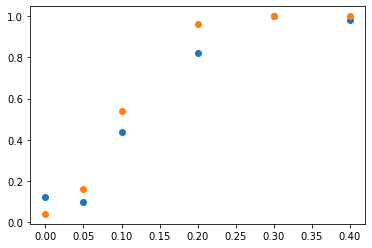

In [26]:
plt.scatter(COVS, [get_null_rejection_rate(hsic_results[cov]) for cov in COVS])
plt.scatter(COVS, [get_cov_null_rejection_rate(cov_results[cov]) for cov in COVS])

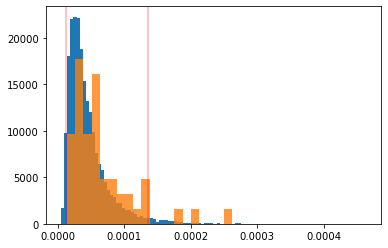

In [36]:
plt.hist(null, bins = 100, density = True);
plt.hist(test_statistic_dists[0], bins = 20, density = True, alpha = 0.8)
plt.axvline(low_thresh, alpha = 0.3, color = 'red')
plt.axvline(high_thresh, alpha = 0.3, color = 'red')

In [28]:
def push_results():
    BIG_RESULT_MEMORY_PLACE.append({
        'N_TIMESTEPS' : N_TIMESTEPS,
        'NO_TIMESTEPS_PER_SAMPLE' : int(N_TIMESTEPS / SIG_KERNEL_SAMPLES_NO),
        'SIG_KERNEL_SAMPLES_NO' : SIG_KERNEL_SAMPLES_NO,
        'M_RUNS' : M_RUNS,
        'COVS' : COVS,
        'COV RESULTS' : cov_results,
        'PROC_DIV' : PROC_DIV,
        'RBF_SIGMA' : RBF_SIGMA,
        'NULL' : null,
        'TEST DISTS' : test_statistic_dists,
        'TEST HIGH LOW THRES': (high_thresh, low_thresh),
        'COMMENT' : 'Using the V_statistic now, faster and also seems reliable'
    })
    pp.pprint(BIG_RESULT_MEMORY_PLACE[-1])

In [29]:
push_results()

{   'COMMENT': 'Using the V_statistic now, faster and also seems reliable',
    'COV RESULTS': {   0: [   (tensor(-0.0222), 0.5637762016029908),
                              (tensor(-0.1464), 0.8555494894912712),
                              (tensor(0.0224), 0.42310667416729053),
                              (tensor(-0.0653), 0.6785299932816475),
                              (tensor(-0.2495), 0.9441534752214008),
                              (tensor(-0.2307), 0.9580212389119143),
                              (tensor(-0.0068), 0.5185675384514798),
                              (tensor(-0.1428), 0.8732500765961182),
                              (tensor(-0.1064), 0.7436313912901735),
                              (tensor(-0.0056), 0.5173030759383901),
                              (tensor(0.0981), 0.2287774081873668),
                              (tensor(0.0454), 0.36386043976343263),
                              (tensor(-0.0448), 0.6065079247111943),
                            

                                (tensor(1.1612), 0.0),
                                (tensor(1.1365), 7.66053886991358e-15),
                                (tensor(0.8592), 1.8681056701552734e-11),
                                (tensor(1.3441), 0.0),
                                (tensor(1.1694), 0.0),
                                (tensor(1.1079), 1.1102230246251565e-16),
                                (tensor(1.2764), 0.0),
                                (tensor(1.3310), 0.0),
                                (tensor(1.2122), 2.220446049250313e-16),
                                (tensor(1.0580), 3.297362383136715e-14),
                                (tensor(1.3400), 0.0),
                                (tensor(0.9852), 2.220446049250313e-16),
                                (tensor(1.0444), 2.824407374646398e-13),
                                (tensor(1.2405), 1.1102230246251565e-16),
                                (tensor(1.1256), 1.1102230246251565e-16),
          

In [30]:
import datetime

In [31]:
import pickle
with open('./corr_vs_hsic_comparison_BIG_RESULTS_{}.pickle'.format(datetime.datetime.today()).replace(' ', '_').replace(':', '.'), 'wb') as f:
    pickle.dump(BIG_RESULT_MEMORY_PLACE, f)